Found 25000 files belonging to 5 classes.
Using 20000 files for training.
Found 25000 files belonging to 5 classes.
Using 5000 files for validation.
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 283ms/step - accuracy: 0.5306 - loss: 1.1685 - val_accuracy: 0.8578 - val_loss: 0.3999
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 172s 275ms/step - accuracy: 0.8482 - loss: 0.4187 - val_accuracy: 0.9134 - val_loss: 0.2374
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 172s 276ms/step - accuracy: 0.9039 - loss: 0.2667 - val_accuracy: 0.9416 - val_loss: 0.1603
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 172s 276ms/step - accuracy: 0.9311 - loss: 0.1961 - val_accuracy: 0.9588 - val_loss: 0.1106
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 172s 275ms/step - accuracy: 0.9513 - loss: 0.1446 - val_accuracy: 0.9684 - val_loss: 0.0929
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 175s 279ms/step - accuracy: 0.9608 - loss: 0.1151 - val_accuracy: 0.9776 - val_loss: 0.0670
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 173s 277ms/step - a

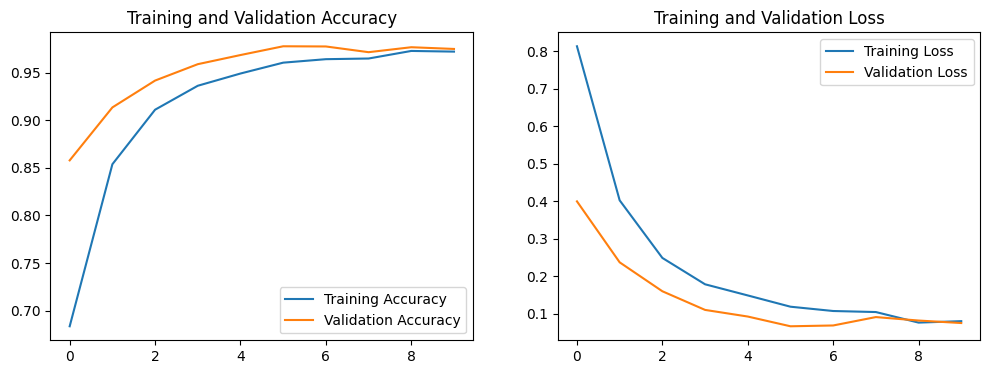

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Path to your dataset
DATASET_PATH = r"C:\Users\kashi\Desktop\LY Project\Multi Cancer\Multi Cancer\Cervical Cancer"

# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = val_ds.class_names
num_classes = len(class_names)

# Normalize pixel values
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Build CNN model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train initial model
initial_epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs
)

# Fine-tune: recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs
)

# Plotting training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

# Classification Report & ROC
print("\n📋 Classification Report:")
y_true = []
y_pred = []
y_score = []

for images, labels in val_ds:
    probs = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(probs, axis=1))
    y_score.extend(probs)

print(classification_report(y_true, y_pred, target_names=class_names))
print("\n✅ Accuracy Score:", accuracy_score(y_true, y_pred))

try:
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_score = np.array(y_score)
    auc_score = roc_auc_score(y_true_bin, y_score, multi_class='ovr')
    print(f"ROC-AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr = dict()
    tpr = dict()
    roc_auc_individual = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc_individual[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc_individual[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multi-Class')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

except Exception as e:
    print("Could not compute AUC:", e)
